# 基于模板匹配的车牌识别

## 1、项目准备

In [106]:
# 导入所需模块
import cv2
from matplotlib import pyplot as plt
import os
import numpy as np

In [107]:
# 定义必要函数

# 显示图片
def cv_show(name,img):
    cv2.imshow(name,img)
    cv2.waitKey()
    cv2.destroyAllWindows()

# plt显示彩色图片
def plt_show0(img):
    b,g,r = cv2.split(img)
    img = cv2.merge([r, g, b])
    plt.imshow(img)
    plt.show()
    
# plt显示灰度图片
def plt_show(img):
    plt.imshow(img,cmap='gray')
    plt.show()

# 图像去噪灰度处理
def gray_guss(image):
    image = cv2.GaussianBlur(image, (3, 3), 0)
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return gray_image

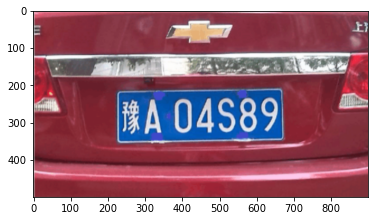

In [108]:
# 读取待检测图片
origin_image = cv2.imread('./image/test2.png')
plt_show0(origin_image)

## 2、提取车牌位置图片

In [109]:
# 提取车牌部分图片
def get_carLicense_img(image):
    gray_image = gray_guss(image)
    Sobel_x = cv2.Sobel(gray_image, cv2.CV_16S, 1, 0)
    absX = cv2.convertScaleAbs(Sobel_x)
    image = absX
    ret, image = cv2.threshold(image, 0, 255, cv2.THRESH_OTSU)
    kernelX = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 5))
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernelX,iterations = 3)
    kernelX = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 1))
    kernelY = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 19))
    image = cv2.dilate(image, kernelX)
    image = cv2.erode(image, kernelX)
    image = cv2.erode(image, kernelY)
    image = cv2.dilate(image, kernelY)
    image = cv2.medianBlur(image, 15)
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for item in contours:
        rect = cv2.boundingRect(item)
        x = rect[0]
        y = rect[1]
        weight = rect[2]
        height = rect[3]
        if (weight > (height * 3)) and (weight < (height * 4)):
            image = origin_image[y:y + height, x:x + weight]
            return image

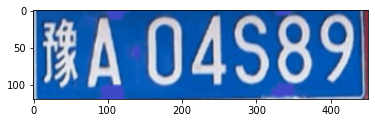

In [110]:
image = origin_image.copy()
carLicense_image = get_carLicense_img(image)
plt_show0(carLicense_image)

## 3、车牌字符分割

In [111]:
def carLicense_spilte(image):
    gray_image = gray_guss(image)
    ret, image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_OTSU)
    plt_show(image)
    # 计算二值图像黑白点的个数，处理绿牌照问题，让车牌号码始终为白色
    area_white = 0
    area_black = 0
    height, width = image.shape
    for i in range(height):
        for j in range(width):
            if image[i, j] == 255:
                area_white += 1
            else:
                area_black += 1
    if area_white>area_black:
        ret, image = cv2.threshold(image, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
        plt_show(image)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    image = cv2.dilate(image, kernel)
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    words = []
    word_images = []
    for item in contours:
        word = []
        rect = cv2.boundingRect(item)
        x = rect[0]
        y = rect[1]
        weight = rect[2]
        height = rect[3]
        word.append(x)
        word.append(y)
        word.append(weight)
        word.append(height)
        words.append(word)
    words = sorted(words,key=lambda s:s[0],reverse=False)
    i = 0
    for word in words:
        if (word[3] > (word[2] * 1.8)) and (word[3] < (word[2] * 3.5)):
            i = i+1
            splite_image = image[word[1]:word[1] + word[3], word[0]:word[0] + word[2]]
            word_images.append(splite_image)
    return word_images

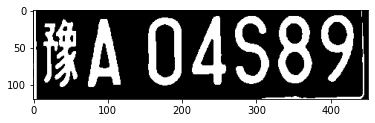

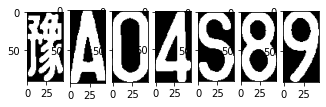

In [112]:
image = carLicense_image.copy()
word_images = carLicense_spilte(image)

# 绿牌要改为8，蓝牌为7，显示所用
for i,j in enumerate(word_images):  
    plt.subplot(1,8,i+1)
    plt.imshow(word_images[i],cmap='gray')
    cv2.imwrite('./words/test1_'+str(i+1)+'.png', word_images[i])
plt.show()

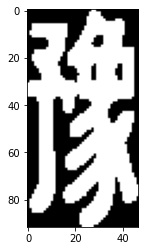

In [113]:
word =  cv2.imread('./words/test1_1.png',0)
plt_show(word)

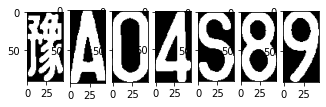

In [128]:
word_images = []
for i in range(1,8):
    word =  cv2.imread('./words/test1_'+str(i)+'.png',0)
    ret, word = cv2.threshold(word, 0, 255, cv2.THRESH_OTSU)
    word_images.append(word)
word_images
plt.imshow(word_images[0],cmap='gray')    
for i,j in enumerate(word_images):  
    plt.subplot(1,8,i+1)
    plt.imshow(word_images[i],cmap='gray')
plt.show()

## 4、模板匹配

In [129]:
# 准备模板
template = ['0','1','2','3','4','5','6','7','8','9',
            'A','B','C','D','E','F','G','H','J','K','L','M','N','P','Q','R','S','T','U','V','W','X','Y','Z',
            '藏','川','鄂','甘','赣','贵','桂','黑','沪','吉','冀','津','晋','京','辽','鲁','蒙','闽','宁',
            '青','琼','陕','苏','皖','湘','新','渝','豫','粤','云','浙']

# 读取一个文件夹下的所有图片，输入参数是文件名，返回文件地址列表
def read_directory(directory_name):
    referImg_list = []
    for filename in os.listdir(directory_name):
        referImg_list.append(directory_name + "/" + filename)
    return referImg_list

# 中文模板列表（只匹配车牌的第一个字符）
def get_chinese_words_list():
    chinese_words_list = []
    for i in range(34,64):
        c_word = read_directory('./refer1/'+ template[i])
        chinese_words_list.append(c_word)
    return chinese_words_list
chinese_words_list = get_chinese_words_list()

# 英文模板列表（只匹配车牌的第二个字符）
def get_eng_words_list():
    eng_words_list = []
    for i in range(10,34):
        e_word = read_directory('./refer1/'+ template[i])
        eng_words_list.append(e_word)
    return eng_words_list
eng_words_list = get_eng_words_list()

# 英文数字模板列表（匹配车牌后面的字符）
def get_eng_num_words_list():
    eng_num_words_list = []
    for i in range(0,34):
        word = read_directory('./refer1/'+ template[i])
        eng_num_words_list.append(word)
    return eng_num_words_list
eng_num_words_list = get_eng_num_words_list()


# 读取一个模板地址与图片进行匹配，返回匹配得分
def template_score(template,image):
    template_img=cv2.imdecode(np.fromfile(template,dtype=np.uint8),1)
    template_img = cv2.cvtColor(template_img, cv2.COLOR_RGB2GRAY)
    ret, template_img = cv2.threshold(template_img, 0, 255, cv2.THRESH_OTSU)
    image_ = image.copy()
    height, width = image_.shape
    template_img = cv2.resize(template_img, (width, height))
    result = cv2.matchTemplate(image_, template_img, cv2.TM_CCOEFF)
    return result[0][0]

In [130]:
print(template[0]) # 第一数字
print(template[10]) # 第一个字母
print(template[34]) # 第一个中文字

0
A
藏


In [131]:
# 模板匹配
def template_matching(word_images):
    results = []
    for index,word_image in enumerate(word_images):
        # 匹配车牌第一位中文字符
        if index==0:
            best_score = []
            for chinese_word_list in chinese_words_list:
                score = []
                for chinese_word in chinese_word_list:
                    result = template_score(chinese_word,word_image)
                    score.append(result)
                best_score.append(max(score))
            print(best_score)
            i = best_score.index(max(best_score))
            print(template[34+i])
            r = template[34+i]
            results.append(r)
            continue
        # 匹配第二位一定是字母的情况
        if index==1:
            best_score = []
            for eng_word_list in eng_words_list:
                score = []
                for eng_word in eng_word_list:
                    result = template_score(eng_word,word_image)
                    score.append(result)
                best_score.append(max(score))
            i = best_score.index(max(best_score))
            print(template[10+i])
            r = template[10+i]
            results.append(r)
            continue
        # 其余车牌字符（数字和字母）
        else:
            best_score = []
            for eng_num_word_list in eng_num_words_list:
                score = []
                for eng_num_word in eng_num_word_list:
                    result = template_score(eng_num_word,word_image)
                    score.append(result)
                best_score.append(max(score))
            i = best_score.index(max(best_score))
            print(template[i])
            r = template[i]
            results.append(r)
            continue
    return results

In [132]:
word_images_ = word_images.copy()
result = template_matching(word_images_)
print(result)

[17047542.0, 19597602.0, 20701286.0, 22757138.0, 18244518.0, 23276922.0, 15931846.0, 19425678.0, 16450643.0, 19644004.0, 19502092.0, 26847568.0, 18803894.0, 19494082.0, 15936372.0, 17051772.0, 21058424.0, 17824656.0, 13395950.0, 20458890.0, 22947334.0, 21114002.0, 16497412.0, 23061104.0, 24219562.0, 14903065.0, 17518064.0, 40384100.0, 21126418.0, 10719316.0]
豫
A
0
4
S
8
9
['豫', 'A', '0', '4', 'S', '8', '9']


## 5、结果渲染

In [133]:
r=''
for i in result:
    r+=i

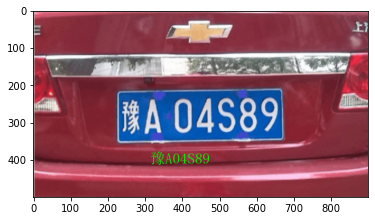

In [135]:
from PIL import Image,ImageDraw,ImageFont
import numpy as np
image = origin_image.copy()
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = Image.fromarray(image)
draw = ImageDraw.Draw(image)
#文字位置
position = (int(0.35*weight), int(0.75*height))
#字体 字体与大小 (字体文件采用windows自带的，在如下目录里面)
font = ImageFont.truetype(r"C:/Windows/Fonts/simsun.ttc", 40)
#颜色 rgb格式
fill = (0,255,0)
draw.text(position,r,fill,font)
image = cv2.cvtColor(np.asarray(image), cv2.COLOR_RGB2BGR)
plt_show0(image)

## 6、总结
 - 项目的容错性还不够高，图片比较模糊的时候识别不到车牌，还待提高
 - 识别速度不够快
 - 模板匹配算法太依赖模板的质量
 - 使用大量的模板可以提高精度，但是速度下降严重
 - 还有很多待优化的地方，比如一张图中有多个车牌等
 - 我认为整个项目最难的地方是车牌位置的提取
 - 项目还是很不错的一个对OpenCV图像处理的课题项目
 - 自己独立完成，收获挺大的
 - 作者：bhml
 - 日期：2020-4-13